# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math


In [3]:
try: 
    data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
    display(data.head()) #просмотр первых строк таблицы
except ConnectionError: 
    print('Try again later please')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


### Предобработка данных

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [5]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.000000,2.369900e+04,23699.000000,23699.000000,14504.000000,23613.000000,21796.000000,23699.000000,21421.000000,12180.000000,18157.000000,18180.000000,18181.000000,8079.000000,18181.000000,9110.000000,20518.000000
mean,9.858475,6.541549e+06,60.348651,2.070636,2.771499,10.673824,34.457852,5.892358,10.569807,1.150082,28793.672193,14191.277833,0.611408,490.804555,0.770255,517.980900,180.888634
std,5.682529,1.088701e+07,35.654083,1.078405,1.261056,6.597173,22.030445,4.885249,5.905438,1.071300,12630.880622,8608.386210,0.802074,342.317995,0.938346,277.720643,219.727988
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.520000,5.000000,18.600000,2.000000,7.000000,0.000000,18585.000000,9238.000000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,1.000000,26726.000000,13098.500000,0.000000,455.000000,1.000000,502.000000,95.000000
75%,14.000000,6.800000e+06,69.900000,3.000000,2.800000,16.000000,42.300000,8.000000,12.000000,2.000000,37273.000000,16293.000000,1.000000,612.000000,1.000000,729.000000,232.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


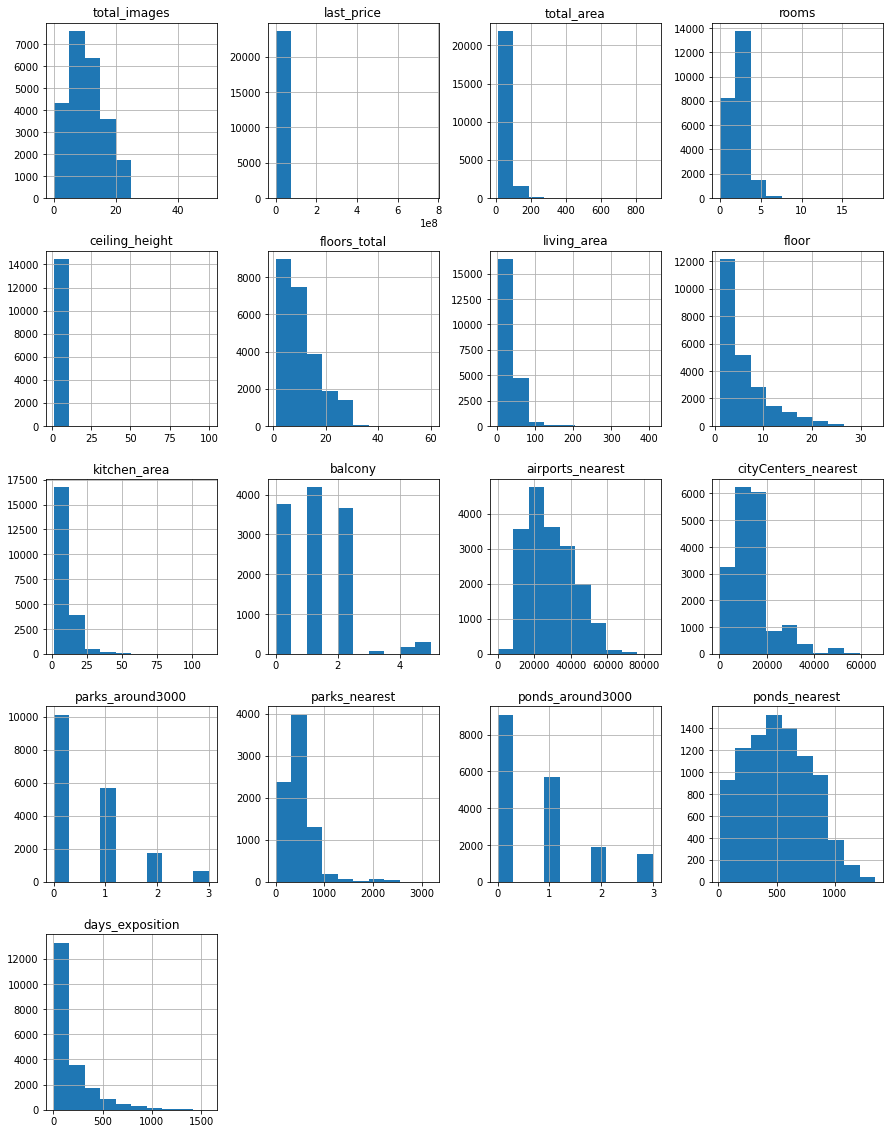

In [6]:
#Построим общую гистограмму для всех числовых столбцов таблицы
data.hist(figsize=(15, 20))
plt.show()

In [7]:
#Переименуем столбец для лучшей читабельности и по стандартам
data.rename(columns={'cityCenters_nearest' : 'city_centers_nearest'}, inplace=True)

После просмотра полученных данных можно выделить следующее:

- Всего в файле содержится - 23 669 строк.
- В данных столбцах отсутствуют какие-либо пропуски: total_images, last_price, total_area, rooms, floor, studio, open_plan, living_area.
- Столбцы floors_total и locality_name заполнены информацией на более 98% строк, в последствии можно будет удалить малозначимые строки.
- В столбце balcony  пропусков - 12 180, предположительно в квартирах балконы отсутствуют и эти пропуски можно олбозначить нулем.


In [8]:
#проверяем датасет на наличие дубликатов
print(data.duplicated().sum())


0


In [9]:
#также нужно преобразовать нули в балконах к целочисленным значениям, так как python их запишет по умолчанию в вещественные
data['balcony'] = data['balcony'].fillna(0).astype(int)

    В столбце "floors_total" из 23 699 строк заполнено 23 613, не заполнено – 86. Максимальный этаж – 60, количество квартир с этажностью более 30 этажей – 32. Удалить нужно 86, в которых не было заполнено количество этажей.

In [10]:
data=data.dropna(subset=['floors_total'])

    В столбце "ceiling_height" из 23 699 строк заполнено 14 504. Кол-во квартир с высотой потолка более чем 10 м. – 25, предположительно это ошибки, так как особой роли они не играют - не будем их трогать, но в данных есть строка “ nan”, которую нужно удалить.
    Пропуски в столбце "ceiling_height" можно заменить на медианы значений высот потолков по каждому этажу. Для этого можно написать цикл. 

In [11]:
print(data['ceiling_height'].unique())

[  2.7     nan   3.03   2.5    2.67   2.56   3.05   2.75   2.6    2.9
   2.8    2.55   3.     2.65   3.2    2.61   3.25   3.45   2.77   2.85
   2.64   2.57   4.15   3.5    3.3    2.71   4.     2.47   2.73   2.84
   3.1    2.34   3.4    3.06   2.72   2.54   2.51   2.78   2.76  25.
   2.58   3.7    2.52   5.2    2.87   2.66   2.59   2.     2.45   3.6
   2.92   3.11   3.13   3.8    3.15   3.55   3.16   3.62   3.12   2.53
   2.74   2.96   2.46   5.3    5.     2.79   2.95   4.06   2.94   3.82
   3.54   3.53   2.83   4.7    2.4    3.38   3.01   5.6    3.65   3.9
   3.18   3.35   2.3    3.57   2.48   2.62   2.82   3.98   2.63   3.83
   3.52   3.95   3.75   2.88   3.67   3.87   3.66   3.85   3.86   4.19
   3.24   4.8    4.5    4.2    3.36  32.     3.08   3.68   3.07   3.37
   3.09   8.     3.26   3.34   2.81   3.44   2.97   3.14   4.37   2.68
   3.22   3.27  27.     4.1    2.93   3.46  24.     3.47   3.33   3.63
   3.32  26.     1.2    8.3    2.98   2.86   3.17   4.4    3.28   3.04
   4.45   5

In [12]:
med_replace = data.groupby('floors_total')['ceiling_height'].median()
for floor in data['floors_total'].unique():
    data.loc[(data['floors_total'] == floor) & (data['ceiling_height'].isna()), 'ceiling_height'] = med_replace[floor]

#Также нужно исключить строки с высотой потолков более 10 м,чтобы не было ошибок
data.loc[data['ceiling_height'] > 10,'ceiling_height'] = None
data = data.dropna(subset=['ceiling_height'])
print(data['ceiling_height'][data['ceiling_height'] > 10].count())
data.info()
display(data['ceiling_height'].unique())

0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 23586 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23586 non-null  int64  
 1   last_price            23586 non-null  float64
 2   total_area            23586 non-null  float64
 3   first_day_exposition  23586 non-null  object 
 4   rooms                 23586 non-null  int64  
 5   ceiling_height        23586 non-null  float64
 6   floors_total          23586 non-null  float64
 7   living_area           21716 non-null  float64
 8   floor                 23586 non-null  int64  
 9   is_apartment          2762 non-null   object 
 10  studio                23586 non-null  bool   
 11  open_plan             23586 non-null  bool   
 12  kitchen_area          21360 non-null  float64
 13  balcony               23586 non-null  int64  
 14  locality_name         23538 non-null  object 
 15  airports_nearest 

array([2.7 , 2.75, 2.55, 2.6 , 3.03, 2.65, 2.66, 2.5 , 2.67, 2.56, 3.  ,
       3.05, 2.8 , 2.9 , 3.2 , 2.61, 3.25, 3.45, 2.77, 2.85, 2.64, 2.57,
       4.15, 3.5 , 3.3 , 2.71, 4.  , 2.47, 2.73, 2.84, 3.1 , 2.34, 3.4 ,
       3.06, 2.72, 2.54, 2.51, 2.78, 2.76, 2.58, 3.7 , 2.52, 5.2 , 2.87,
       2.59, 2.  , 2.45, 3.6 , 2.92, 3.11, 3.13, 3.8 , 3.15, 3.55, 3.16,
       3.62, 3.12, 2.53, 2.74, 2.96, 2.46, 5.3 , 5.  , 2.79, 2.95, 4.06,
       2.94, 3.82, 3.54, 3.53, 2.83, 4.7 , 2.4 , 3.38, 3.01, 5.6 , 3.65,
       3.9 , 3.18, 3.35, 2.3 , 3.57, 2.48, 2.62, 2.82, 3.98, 2.63, 3.83,
       3.52, 3.95, 3.75, 2.88, 3.67, 3.87, 3.66, 3.85, 3.86, 4.19, 3.24,
       4.8 , 4.5 , 4.2 , 3.36, 3.08, 3.68, 3.07, 3.37, 3.09, 8.  , 3.26,
       3.34, 2.81, 3.44, 2.97, 3.14, 4.37, 2.68, 3.22, 3.27, 4.1 , 2.93,
       3.46, 3.47, 3.33, 3.63, 3.32, 1.2 , 8.3 , 2.98, 2.86, 3.17, 4.4 ,
       3.28, 3.04, 4.45, 5.5 , 3.84, 3.23, 3.02, 3.21, 3.43, 3.78, 4.3 ,
       3.39, 2.69, 3.31, 4.65, 3.56, 2.2 , 3.51, 3.

Пропуски в столбце "kitchen_area" нужно заменить на медианы значений площади кухни по каждому значению кол-ва комнат столбца "rooms". Для пишется цикл, перебирающий уникальные значения столбца 'rooms' и в случае пропуска в столбце 'kitchen_area', заменит на медианное значение площади кухни.

In [13]:
med_replace_kitchen = data.groupby('rooms')['kitchen_area'].median()
for room in data['rooms'].unique():
    data.loc[(data['rooms'] == room) & (data['kitchen_area'].isna()), 'kitchen_area'] = med_replace_kitchen[room]
display(data['kitchen_area'].value_counts())

# Исключим 193 строки с записью "  nan", как вероятные ошибки данных.
data.loc[data['kitchen_area'] == '  nan','kitchen_area'] = None
data = data.dropna(subset=['kitchen_area'])
display(data['kitchen_area'].unique())

9.00     1908
6.00     1300
10.00    1261
8.00     1108
7.00     1060
         ... 
7.78        1
7.12        1
13.73       1
14.74       1
16.74       1
Name: kitchen_area, Length: 967, dtype: int64

array([ 25.  ,  11.  ,   8.3 ,   9.5 ,  41.  ,   9.1 ,  14.4 ,  18.9 ,
         8.81,   6.5 ,   8.5 ,   6.  ,   9.  ,   5.2 ,   8.  ,   7.6 ,
         5.6 ,  12.  ,   5.7 ,   6.1 ,  19.6 ,  15.  ,   7.  ,   9.2 ,
        11.7 ,  13.4 ,  17.  ,   6.3 ,   8.7 ,  11.6 ,   8.8 ,  10.  ,
        17.6 ,   7.5 ,  50.  ,  15.5 ,  10.7 ,  11.1 ,  20.  ,  11.9 ,
        16.  ,   5.3 ,  11.5 ,   7.2 ,   6.2 ,  10.4 ,   7.1 ,   4.9 ,
         7.3 ,  11.95,  10.2 ,   6.4 ,   5.5 ,  13.  ,   8.4 ,  23.6 ,
        10.8 ,  18.3 ,   5.  ,   8.2 ,  24.  ,  23.8 ,   6.6 ,  26.85,
        15.4 ,   7.8 ,  33.8 ,   5.4 ,  12.72,  12.2 ,  19.  ,  12.4 ,
         7.9 ,  10.3 ,   9.8 ,  17.5 ,  14.7 ,  20.91,  21.3 ,  10.6 ,
        10.9 ,   9.7 ,   7.7 ,  12.5 ,  11.4 ,   8.6 ,  11.24,  14.1 ,
        15.7 ,  13.29,  14.  ,  12.9 ,  12.7 ,  16.5 ,   9.36,  21.5 ,
        35.  ,  10.5 ,  19.3 ,  21.4 ,  40.  ,  49.2 ,  11.52,   8.9 ,
         9.6 ,  30.  ,  14.2 ,   8.1 ,  10.44,   4.5 ,  16.3 ,  11.2 ,
      

Подобные действия проделаем и со столбцом "living_area"

In [14]:
med_replace_rooms = data.groupby('rooms')['living_area'].median()
for room in data['rooms'].unique():
    data.loc[(data['rooms'] == room) & (data['living_area'].isna()), 'living_area'] = med_replace_rooms[room]

In [15]:
# добавим в таблицу столбец "living_total" соотношение жилой и общей площади
data['living_total'] = data['living_area'] / data['total_area']
#display(data.head())

In [16]:
# добавим в таблицу столбец "kitchen_total" отношение площади кухни к общей
data['kitchen_total'] = data['kitchen_area'] / data['total_area']
display(data.head())

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,living_total,kitchen_total
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,0.472222,0.231481
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,2.75,11.0,18.6,1,NaN,...,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,0.460396,0.272277
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,2.55,5.0,34.3,4,NaN,...,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,0.612500,0.148214
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,2.60,14.0,45.0,9,NaN,...,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,0.283019,0.059748
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,0.320000,0.410000


In [17]:
#Столбец 'floors_total' нужно преобразовать к целочисленному типу данных 'int'
data['floors_total'] = data['floors_total'].astype(int)
display(data['floors_total'].value_counts())

5     5771
9     3747
16    1357
12    1355
4     1194
10    1168
25    1048
6      910
17     814
3      661
7      589
14     543
18     492
24     453
8      388
2      381
15     361
23     346
19     330
22     282
20     265
13     229
11     200
27     162
21     151
26     122
1       25
35      22
28      21
36       1
37       1
52       1
60       1
29       1
34       1
Name: floors_total, dtype: int64

In [18]:
print(data['locality_name'].unique())

['Санкт-Петербург' 'посёлок Шушары' 'городской посёлок Янино-1'
 'посёлок Парголово' 'посёлок Мурино' 'Ломоносов' 'Сертолово' 'Петергоф'
 'Пушкин' 'деревня Кудрово' 'Коммунар' 'Колпино'
 'поселок городского типа Красный Бор' 'Гатчина' 'поселок Мурино'
 'деревня Фёдоровское' 'Выборг' 'Кронштадт' 'Кировск'
 'деревня Новое Девяткино' 'посёлок Металлострой'
 'посёлок городского типа Лебяжье' 'посёлок городского типа Сиверский'
 'поселок Молодцово' 'поселок городского типа Кузьмоловский'
 'садовое товарищество Новая Ропша' 'Павловск' 'деревня Пикколово'
 'Всеволожск' 'Волхов' 'Кингисепп' 'Приозерск' 'Сестрорецк'
 'деревня Куттузи' 'посёлок Аннино' 'поселок городского типа Ефимовский'
 'посёлок Плодовое' 'деревня Заклинье' 'поселок Торковичи'
 'поселок Первомайское' 'Красное Село' 'посёлок Понтонный' 'Сясьстрой'
 'деревня Старая' 'деревня Лесколово' 'посёлок Новый Свет' 'Сланцы'
 'село Путилово' 'Ивангород' 'Мурино' 'Шлиссельбург' 'Никольское'
 'Зеленогорск' 'Сосновый Бор' 'поселок Новый Све

In [19]:
# приведем к нижнему регистру
data['locality_name'] = data['locality_name'].str.lower()

In [20]:
data['locality_name'] = data['locality_name'].str.replace('городской поселок','поселок городского типа')


In [21]:
# Заменяем все "ё" на "е"
data['locality_name'] = data['locality_name'].str.replace('ё', 'е')
print(data['locality_name'].value_counts())

санкт-петербург        15525
поселок мурино           525
поселок шушары           435
всеволожск               392
пушкин                   369
                       ...  
поселок володарское        1
поселок ромашки            1
деревня лаврики            1
поселок кирпичное          1
деревня ялгино             1
Name: locality_name, Length: 327, dtype: int64


Устранение выбросов

In [22]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,living_total,kitchen_total
count,23393.000000,2.339300e+04,23393.000000,23393.000000,23393.000000,23393.000000,23393.000000,23393.000000,23393.000000,23393.000000,17946.000000,17969.000000,17970.000000,8009.000000,17970.000000,8983.000000,20241.000000,23393.000000,23393.000000
mean,9.891250,6.568523e+06,60.602541,2.088403,2.708270,10.621895,34.461493,5.853717,10.457786,0.588381,28817.576674,14189.928488,0.613523,490.217131,0.769226,518.444729,181.554567,0.562996,0.188085
std,5.681502,1.093870e+07,35.618275,1.066432,0.245754,6.564979,21.755603,4.848894,5.670732,0.958339,12621.695833,8630.788469,0.803081,341.528487,0.938832,277.855482,220.099855,0.110194,0.074083
min,0.000000,1.219000e+04,12.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000,0.021583,0.018215
25%,6.000000,3.450000e+06,40.200000,1.000000,2.550000,5.000000,18.500000,2.000000,7.300000,0.000000,18590.000000,9229.000000,0.000000,288.000000,0.000000,294.000000,45.000000,0.489796,0.133333
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.500000,4.000000,9.000000,0.000000,26760.500000,13083.000000,0.000000,454.000000,0.000000,503.000000,96.000000,0.565909,0.172805
75%,14.000000,6.800000e+06,70.000000,3.000000,2.750000,16.000000,42.900000,8.000000,11.500000,1.000000,37273.000000,16285.000000,1.000000,612.000000,1.000000,730.000000,232.000000,0.636778,0.232877
max,50.000000,7.630000e+08,900.000000,19.000000,8.300000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000,1.511905,0.787879


In [23]:
print('Квартир по цене 0:', data.query('last_price == 0')['last_price'].count())
print('Квартир по цене меньше 100.000:', data.query('last_price < 1e+05')['last_price'].count())
print('Квартир по цене больше 100.000.000:', data.query('last_price > 1e+08')['last_price'].count())

print('Квартир по цене больше 100.000.000:', data.query('last_price > 1e+08')['last_price'].count())
data.drop(index=data.query('last_price > 1e+08').index,inplace=True)

Квартир по цене 0: 0
Квартир по цене меньше 100.000: 1
Квартир по цене больше 100.000.000: 37
Квартир по цене больше 100.000.000: 37


Квартир с площадью менее 10 м2: 0
Квартир с площадью более 500 м2: 3


array([[<AxesSubplot:title={'center':'total_area'}>]], dtype=object)

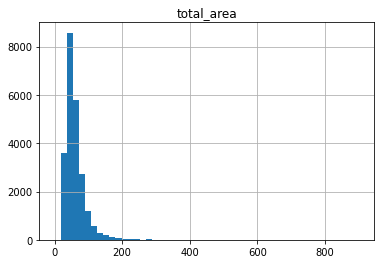

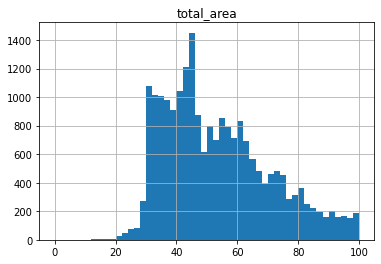

In [24]:
# Рассмотрим площади квартир на аномалии
print('Квартир с площадью менее 10 м2:',data.query('total_area < 10')['total_area'].count()) 
print('Квартир с площадью более 500 м2:',data.query('total_area > 500')['total_area'].count())

data.drop(index=data.query('total_area > 500').index,inplace=True)

data.hist('total_area', bins=50, range=(0,900))
data.hist('total_area', bins=50, range=(0,100))

In [25]:
# Рассмотрим комнаты квартир на аномалии
print('Квартиры с отсутствием комнат:',data.query('rooms == 0')['rooms'].count())

print('Квартиры с отсутствием комнат и студии:',data.query('rooms == 0 and studio')['rooms'].count()) 

print('Квартиры с отсутствием комнат и апартаменты:',data.query('rooms == 0 and is_apartment')['rooms'].count()) 

print('Квартиры с отсутствием комнат и свободная планировка:',data.query('rooms == 0 and open_plan')['rooms'].count())

print('Квартиры с отсутствием комнат, не апартаменты и не свободная планировка:',data.query('rooms == 0 and ~open_plan and ~studio')['rooms'].count())

data.drop(index=data.query('rooms > 7').index,inplace=True)

Квартиры с отсутствием комнат: 0
Квартиры с отсутствием комнат и студии: 0
Квартиры с отсутствием комнат и апартаменты: 0
Квартиры с отсутствием комнат и свободная планировка: 0
Квартиры с отсутствием комнат, не апартаменты и не свободная планировка: 0


Жилая площадь менее 10 кв.м.:  23
Жилая площадь более общей:  29
Жилая площадь более 200:  14


array([[<AxesSubplot:title={'center':'living_area'}>]], dtype=object)

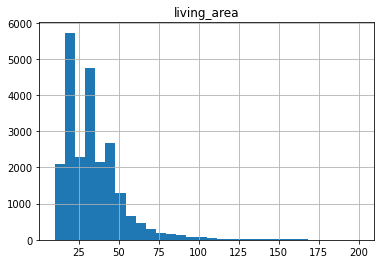

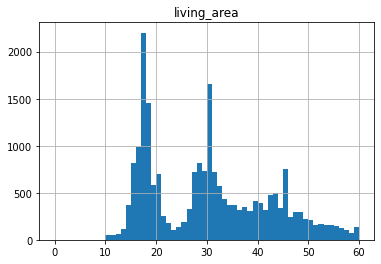

In [26]:
# Рассмотрим жилые площади квартир на аномалии
print('Жилая площадь менее 10 кв.м.: ',data.query('living_area < 10')['living_area'].count())
print('Жилая площадь более общей: ',data.query('living_area > total_area')['living_area'].count())
print('Жилая площадь более 200: ',data.query('living_area > 200')['living_area'].count())

data.drop(index=data.query('living_area < 10').index,inplace=True)
data.drop(index=data.query('living_area > 200').index,inplace=True)

data.hist('living_area', bins=30)
data.hist('living_area', bins=60, range=(0,60))

In [27]:
#Удалим квартиры с высотой потолка менее 2м.
print(data['ceiling_height'][data['ceiling_height'] < 2].count())
data.loc[data['ceiling_height'] < 2,'ceiling_height'] = None
data = data.dropna(subset=['ceiling_height'])
# проверка после удаления
print(data['ceiling_height'][data['ceiling_height'] < 2].count()) 

3
0


In [28]:
#Исключим значения с наименьшей ценой квартиры
data['last_price'][data['last_price'] < 100000].count()
data.loc[data['last_price'] < 100000,'last_price'] = None
data = data.dropna(subset=['last_price'])
data['last_price'][data['last_price'] < 100000].count()

0

In [29]:
#В столбце "is_apartment" нужно заменить пропуски на False, где таковые имеются
data['is_apartment'] = data['is_apartment'].fillna(False)
display(data['is_apartment'].value_counts())

False    23239
True        46
Name: is_apartment, dtype: int64

In [30]:
# удалим такие же пропуски в столбце "locality_name"
data = data.dropna(subset=['locality_name'])

### Посчитайте и добавьте в таблицу новые столбцы

In [31]:
#Считаем цену одного квадратного метра
data['price_area'] = data['last_price'] / data['total_area']
print(data['price_area'])

0        120370.370370
1         82920.792079
2         92785.714286
3        408176.100629
4        100000.000000
             ...      
23694     72490.845228
23695     52542.372881
23696     44091.710758
23697    149511.400651
23698     41795.665635
Name: price_area, Length: 23237, dtype: float64


In [32]:
# столбец "first_day_exposition" сделаем более удобным для просмотра - оставим год, месяц, день
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

In [33]:
#Посчитаем и добавим в таблицу: день публикации объявления
data['day_weekday'] = data['first_day_exposition'].dt.weekday
data['day_month'] = data['first_day_exposition'].dt.month
data['day_year'] = data['first_day_exposition'].dt.year
display(data.head())

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,living_total,kitchen_total,price_area,day_weekday,day_month,day_year
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,482.0,2.0,755.0,NaN,0.472222,0.231481,120370.370370,3,3,2019
1,7,3350000.0,40.4,2018-12-04,1,2.75,11,18.6,1,False,...,NaN,0.0,NaN,81.0,0.460396,0.272277,82920.792079,1,12,2018
2,10,5196000.0,56.0,2015-08-20,2,2.55,5,34.3,4,False,...,90.0,2.0,574.0,558.0,0.612500,0.148214,92785.714286,3,8,2015
3,0,64900000.0,159.0,2015-07-24,3,2.60,14,45.0,9,False,...,84.0,3.0,234.0,424.0,0.283019,0.059748,408176.100629,4,7,2015
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,False,...,112.0,1.0,48.0,121.0,0.320000,0.410000,100000.000000,1,6,2018


In [34]:
#Сделаем в таблице категориальный столбец, где будут определяться этажи - первый, последний и другой
data['floor_group'] = 'другой'
data['floor_group'] = data['floor_group'].where(data['floor'] > 1, 'первый')
data['floor_group'] = data['floor_group'].where(data['floor'] < data['floors_total'], 'последний')
display(data.head())

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,living_total,kitchen_total,price_area,day_weekday,day_month,day_year,floor_group
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,2.0,755.0,NaN,0.472222,0.231481,120370.370370,3,3,2019,другой
1,7,3350000.0,40.4,2018-12-04,1,2.75,11,18.6,1,False,...,0.0,NaN,81.0,0.460396,0.272277,82920.792079,1,12,2018,первый
2,10,5196000.0,56.0,2015-08-20,2,2.55,5,34.3,4,False,...,2.0,574.0,558.0,0.612500,0.148214,92785.714286,3,8,2015,другой
3,0,64900000.0,159.0,2015-07-24,3,2.60,14,45.0,9,False,...,3.0,234.0,424.0,0.283019,0.059748,408176.100629,4,7,2015,другой
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,False,...,1.0,48.0,121.0,0.320000,0.410000,100000.000000,1,6,2018,другой


In [35]:
#Преобразовано расстояние в км до центра города
data['city_centers_nearest'] = round(data['city_centers_nearest']/1000)
display(data['city_centers_nearest'].head())

0    16.0
1    19.0
2    14.0
3     7.0
4     8.0
Name: city_centers_nearest, dtype: float64

### Проведите исследовательский анализ данных

Изучим и опишем следующие параметры:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - цена объекта;
        - количество комнат;
        - высота потолков;
        - этаж квартиры;
        - общее количество этажей в доме;
        - расстояние до центра города в км;
        - расстояние до ближайшего аэропорта;
        - расстояние до ближайшего парка;
        - день и месяц публикации объявления

array([[<AxesSubplot:title={'center':'total_area'}>]], dtype=object)

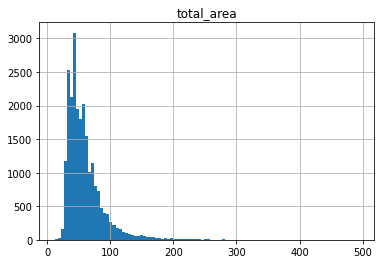

In [36]:
# Общая площадь
data.hist('total_area', bins=100)

array([[<AxesSubplot:title={'center':'living_area'}>]], dtype=object)

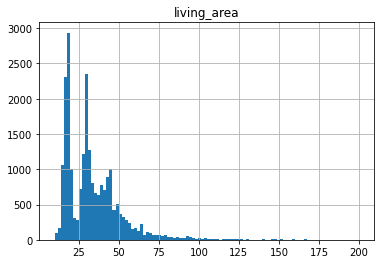

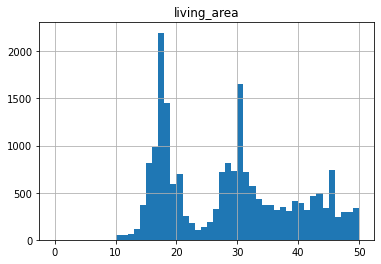

In [37]:
# Жилая площадь
data.hist('living_area', bins=100)
data.hist('living_area', bins=50, range=(0,50))

array([[<AxesSubplot:title={'center':'kitchen_area'}>]], dtype=object)

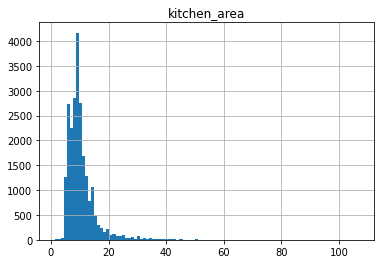

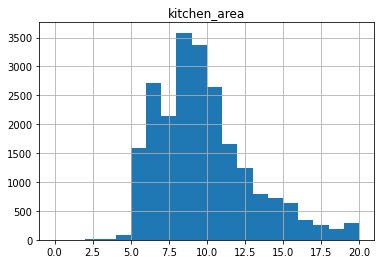

In [38]:
# Площадь кухни
data.hist('kitchen_area', bins=100)
data.hist('kitchen_area', bins=20, range=(0,20))

array([[<AxesSubplot:title={'center':'last_price'}>]], dtype=object)

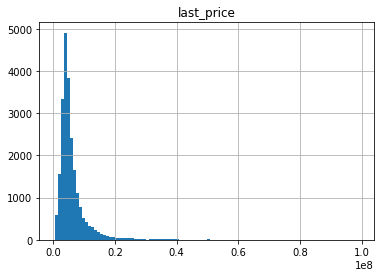

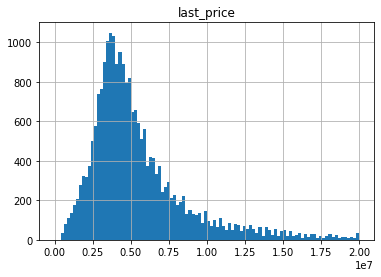

In [39]:
# цена объекта
data.hist('last_price', bins=100)
data.hist('last_price', bins=100, range=(0,2e+07))

array([[<AxesSubplot:title={'center':'rooms'}>]], dtype=object)

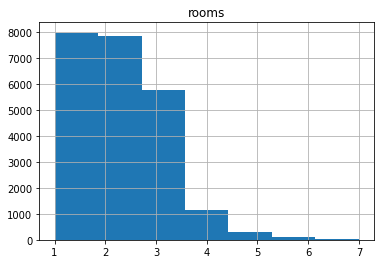

In [40]:
# количество комнат
data.hist('rooms', bins=data['rooms'].max())

array([[<AxesSubplot:title={'center':'ceiling_height'}>]], dtype=object)

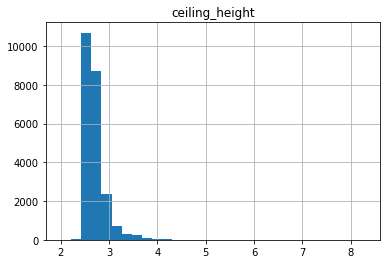

In [41]:
# высота потолков
data.hist('ceiling_height', bins=30)

array([[<AxesSubplot:title={'center':'floor'}>]], dtype=object)

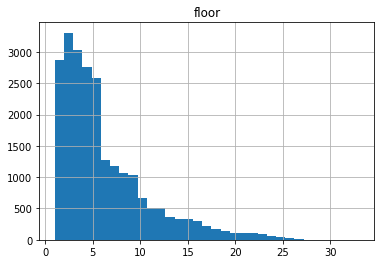

In [42]:
# этаж квартиры
data.hist('floor', bins=data['floor'].max())

array([[<AxesSubplot:title={'center':'floors_total'}>]], dtype=object)

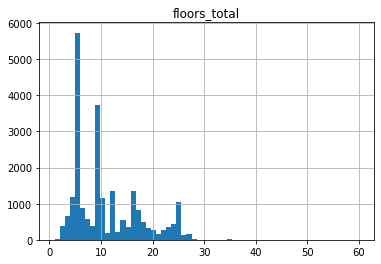

In [43]:
# общее количество этажей в доме
data.hist('floors_total', bins=data['floors_total'].max())

array([[<AxesSubplot:title={'center':'city_centers_nearest'}>]],
      dtype=object)

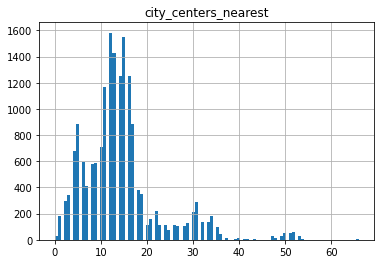

In [44]:
# расстояние до центра города в км
data.hist('city_centers_nearest', bins=100)

array([[<AxesSubplot:title={'center':'airports_nearest'}>]], dtype=object)

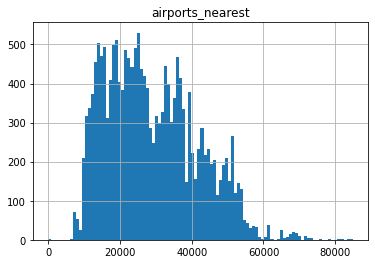

In [45]:
# расстояние до ближайшего аэропорта
data.hist('airports_nearest', bins=100)

array([[<AxesSubplot:title={'center':'parks_nearest'}>]], dtype=object)

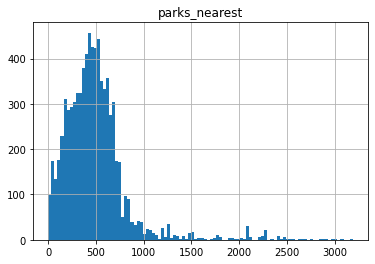

In [46]:
# расстояние до ближайшего парка
data.hist('parks_nearest', bins=100)

<AxesSubplot:>

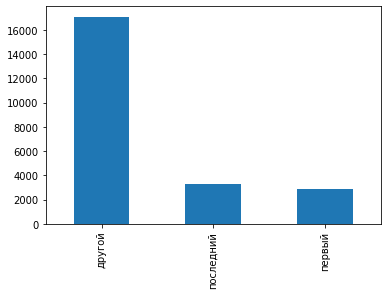

In [47]:
# этаж квартиры
data['floor_group'].value_counts().plot(kind='bar')

    Для изучения и описания следующих параметров - площадь, цена, число комнат, высота потолков - построим гистограммы:

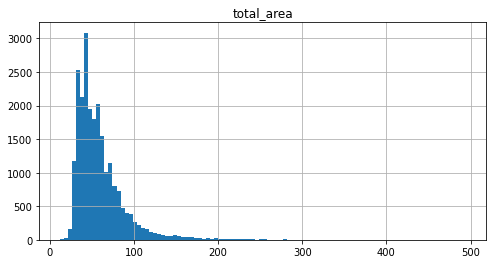

count    23237.000000
mean        59.658311
std         30.934622
min         12.000000
25%         40.100000
50%         52.000000
75%         69.600000
max        494.100000
Name: total_area, dtype: float64


In [48]:
#Гистограмма для столбца площади квартиры
data.hist('total_area', bins=100, figsize = (8,4))
plt.show()
print(data['total_area'].describe())

    Из гистограммы очевидно, что большой спрос у квартир до 80м2, среднее значение площади составляет - 60,6м2.

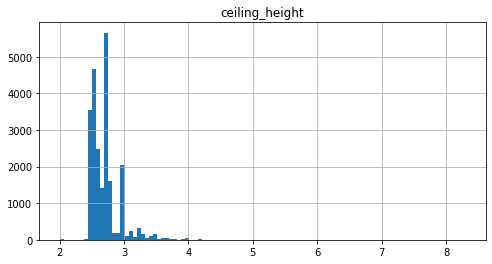

count    23237.000000
mean         2.706055
std          0.239925
min          2.000000
25%          2.550000
50%          2.650000
75%          2.750000
max          8.300000
Name: ceiling_height, dtype: float64


In [49]:
#Гистограмма для столбца высота потолка
data.hist('ceiling_height', bins=100, figsize = (8,4))
plt.show()
print(data['ceiling_height'].describe())

    Из гистограммы можно увидеть, что высота потолков в среднем 2.7м. Максимальная же высота - 8,3м.

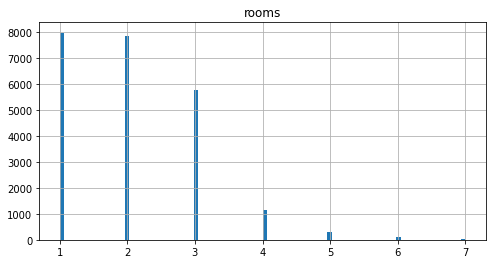

count    23237.000000
mean         2.071266
std          1.011425
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          7.000000
Name: rooms, dtype: float64


In [50]:
# Гистограмма для столбца количество комнат
data.hist('rooms', bins=100, figsize = (8,4))
plt.show()
print(data['rooms'].describe())

    Из гистограммы сразу же выделяется, что наиболее востребованные квартиры - это одно-и двукомнатные, пониже спрос на трехкомнатные квартиры.

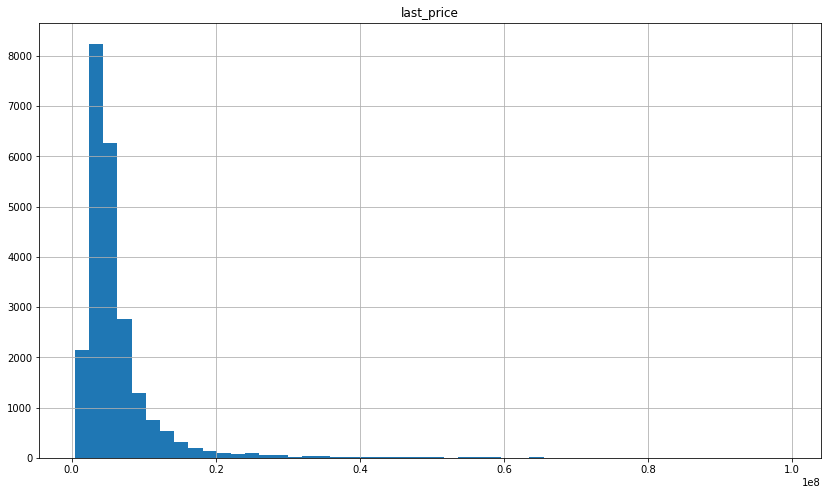

count    2.323700e+04
mean     6.208380e+06
std      6.170306e+06
min      4.300000e+05
25%      3.450000e+06
50%      4.650000e+06
75%      6.760000e+06
max      9.900000e+07
Name: last_price, dtype: float64


In [51]:
# Гистограмма для столбца цены
data.hist('last_price', bins=50, figsize = (14,8))
plt.show()
print(data['last_price'].describe())

    Здесь можно выделить, что большая часть квартир с ценой до 15млн.р., максимальная же стоимость квартиры составляет - 763млн.р.

    Изучим, как быстро продавались квартиры (столбец days_exposition). Этот параметр показывает, сколько дней «висело» каждое объявление.
    - Построим гистограмму.
    - Посчитаем среднее и медиану.
    - В ячейке типа markdown опишем, сколько обычно занимает продажа. Какие продажи можно считать быстрыми, а какие — необычно долгими?"

Чтобы изучить время продажи квартиры - посчитаем среднее и медиану

Среднее время продажи квартиры в днях: 180
Медианное время продажи квартиры в днях: 96

Количество объявлений, которые сняты через:
45 дней: 0
60 дней: 533
90 дней: 0


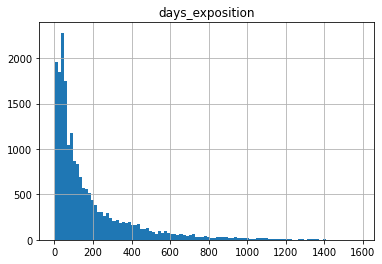

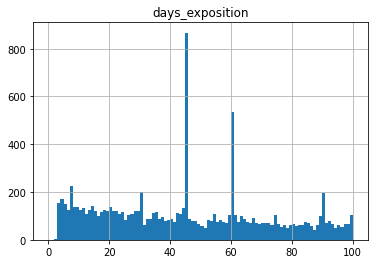

In [52]:
# Гистограмма для столбца "days_exposition"
data.hist('days_exposition', bins=100);
data.hist('days_exposition', bins=100, range = (0, 100));
print(f'Среднее время продажи квартиры в днях:',int(data['days_exposition'].mean()))
print(f'Медианное время продажи квартиры в днях:',int(data['days_exposition'].median()))

print('\nКоличество объявлений, которые сняты через:')
print('45 дней:',data[data['days_exposition']==45]['days_exposition'].count())
print('60 дней:',data[data['days_exposition']==60]['days_exposition'].count())
print('90 дней:',data[data['days_exposition']==90]['days_exposition'].count())

    Из гистограммы видно, что объявления, как правило, размещаются на период до 3 месяцев, что может считаться достаточно быстрой продажей, но также достаточно много объявлений остается более 7-8 месяцев, что относительно очень медленно. Среднее время продажи - 181 день, значение медианы составляет 96 дней.

    Построим коэффициент корреляции квартиры, чтобы рассмотреть, какие факторы больше всего влияют на стоимость.

In [53]:
# Факторы, влияющме главным образом на полную стоимость объекта
list_for_graph = ['total_area',
                  'living_area',
                  'kitchen_area',
                  'rooms',
                  ]

for i in list_for_graph:
    correlation = data['last_price'].corr(data[i])
    print(f'Корреляция между last_price и {i} составляет: {correlation:0.2%}')

Корреляция между last_price и total_area составляет: 75.70%
Корреляция между last_price и living_area составляет: 63.72%
Корреляция между last_price и kitchen_area составляет: 55.37%
Корреляция между last_price и rooms составляет: 45.89%


<AxesSubplot:xlabel='rooms'>

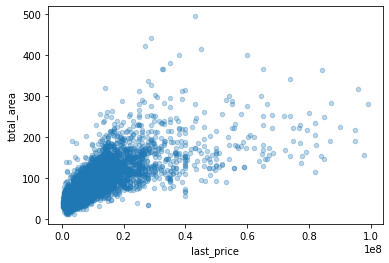

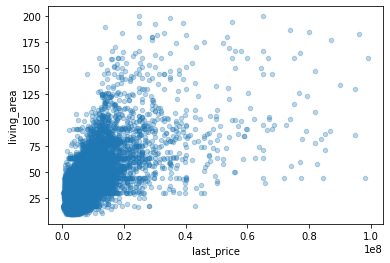

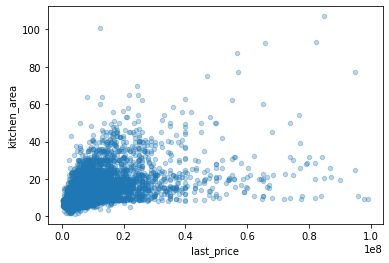

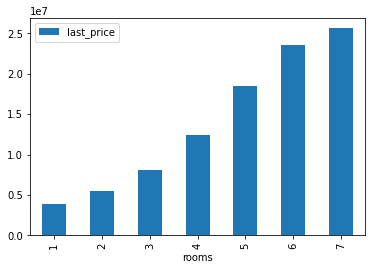

In [54]:
# Построим графики для наглядности
data.plot(x='last_price', y='total_area', kind='scatter', alpha=0.3)
data.plot(x='last_price', y='living_area', kind='scatter', alpha=0.3)
data.plot(x='last_price', y='kitchen_area', kind='scatter', alpha=0.3)
data.pivot_table(index='rooms',values='last_price').plot(y='last_price', kind='bar')

    Оценим зависимость цены квартиры от площади, числа комнат и удалённости от центра

In [1]:
#Зависимость цены одного м2 от площади квартиры
data.query('total_area<200').pivot_table(index='total_area', values='price_area', aggfunc='median').plot(style='o');

NameError: name 'data' is not defined

    Можно проследить некоторую закономерность - чем больше площадь квартиры, тем меньше цена квадратного метра и квартиры в целом.

<AxesSubplot:xlabel='rooms'>

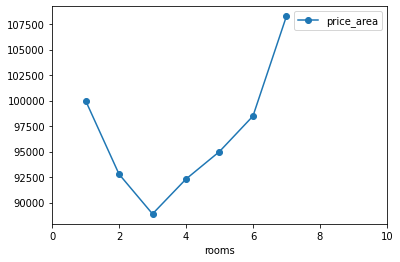

In [56]:
# Оценим зависимость цены одного м2 от числа комнат
data.query('last_price<80000000').pivot_table(index='rooms', values='price_area', aggfunc='median').plot(style='o-', xlim=(0, 10));

    Из графика видно, что цена за один м2 уменьшается при увеличении числа комнат до 3, начиная с 4 комнат, цена м2 увеличивается - эта прогрессия идет до 7 комнат, а далее опять прослеживается снижжение цены за м2.

<AxesSubplot:xlabel='city_centers_nearest'>

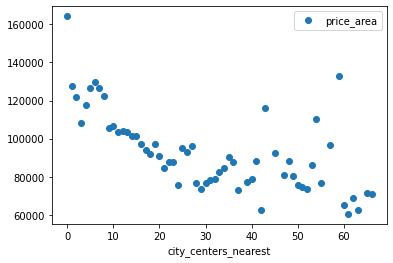

In [57]:
# Оценим зависимость цены одного м2 от удаленности от центра
data.query('last_price<100000000').pivot_table(index='city_centers_nearest', values='price_area', aggfunc='median').plot(style='o');

    Прослеживается прямое влияние расстояния до центра на стоимость квартиры: чем ближе к центру - тем дороже. При расстоянии до центра более 30 км., данная зависимость явно менее выражена.

<AxesSubplot:xlabel='last_price', ylabel='floor_group'>

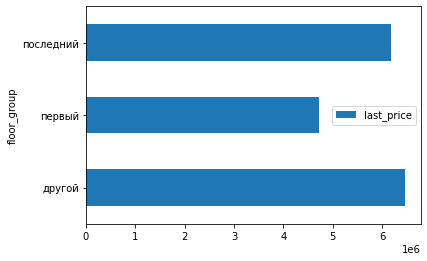

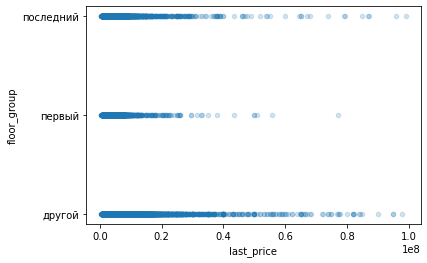

In [58]:
data.pivot_table(index='floor_group',values='last_price').plot(y='last_price', kind='barh');

data.plot(x='last_price', y='floor_group', kind='scatter', alpha=0.2);

    Квартиры на первом и других этажах дешевле чем на последнем. Также на первом этаже цена существенно ниже, чем на других

<AxesSubplot:xlabel='day_weekday'>

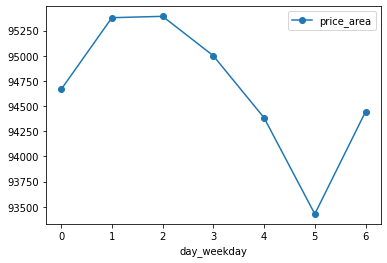

In [59]:
# Оценим зависимость цены м2 от дня размещения объявления
data.query('last_price<100000000').pivot_table(index='day_weekday', values='price_area', aggfunc='median').plot(style='o-');

    Наивысшее значение цены одного м2 у объявлений, которые выставляются в начале недели, наименьшее - у объявлений выставленных в конце недели.

<AxesSubplot:xlabel='day_month'>

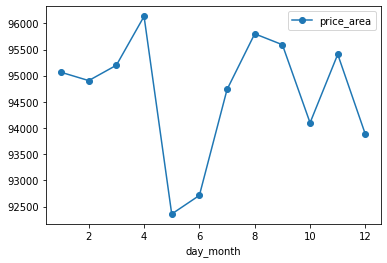

In [60]:
# Оценим зависимость цены м2 от месяца размещения объявления
data.query('last_price<100000000').pivot_table(index='day_month', values='price_area', aggfunc='median').plot(style='o-');

    Наибольшее значение цены одного м2 у объявлений, выставленных в апреле, за которым идет стремительное падение значений и как следствие, оказывается, что сразу же в следующем и последующем месяцах идут самые минимальные значения и по всему году в целом - это май и июнь. Далее через месяц идет "отскок" опять на одно из максимальных значений - август. 

<AxesSubplot:xlabel='day_year'>

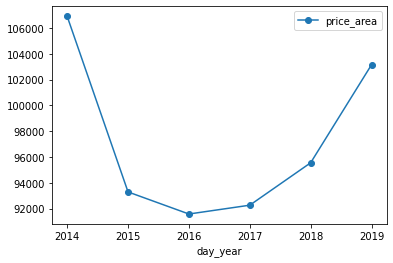

In [61]:
# Оценим зависимость цены одного м2 от года размещения объявления
data.query('last_price<100000000').pivot_table(index='day_year', values='price_area', aggfunc='median').plot(style='o-');

    Наибольшее значение цены м2 у объявлений 14ого года, затем идет плавный спад до 2017г, далее относительно стремительный взлет к 2019г.

    Далее посчитаем среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделим населённые пункты с самой высокой и низкой стоимостью квадратного метра. 

In [62]:
local_ten=data['locality_name'].value_counts().sort_values(ascending=False).head(10)
display(local_ten)

санкт-петербург      15422
поселок мурино         525
поселок шушары         434
всеволожск             392
пушкин                 368
колпино                337
поселок парголово      323
гатчина                306
деревня кудрово        283
выборг                 237
Name: locality_name, dtype: int64

<AxesSubplot:xlabel='locality_name'>

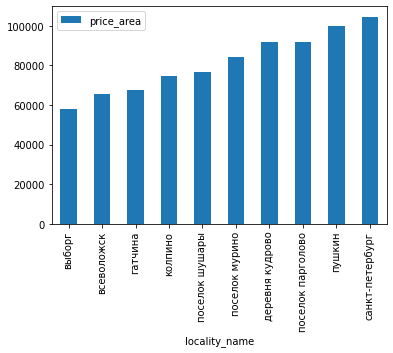

In [63]:
# Посчитаем среднюю цену м2 в этих населённых пунктах, выделим пункты с самой высокой и низкой стоимостью жилья.
data.query('locality_name in @local_ten.index').pivot_table(index='locality_name', values='price_area', aggfunc='median').sort_values('price_area').plot(kind='bar');

    На графике выделяются населённые пункты с самой высокой стоимостью жилья - это Санкт-Петербург и Пушкин, с самой низкой стоимостью - Выборг и Всеволожск.

    Теперь выделим квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислим среднюю цену каждого километра. Опишим, как стоимость объектов зависит от расстояния до центра города.

In [64]:
# Создадим в датасете столбец с расстоянием до центра в километрах, округлим его до целых значений
data['city_centers'] = data['city_centers_nearest'].dropna().astype(int)
data['last_price'].astype(int)

0        13000000
1         3350000
2         5196000
3        64900000
4        10000000
           ...   
23694     9700000
23695     3100000
23696     2500000
23697    11475000
23698     1350000
Name: last_price, Length: 23237, dtype: int64

In [65]:
# посчитаем среднюю цену для каждого километра.
data['price_km'] = data['last_price'] / data['city_centers'].dropna().astype(int)
data.head()


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,days_exposition,living_total,kitchen_total,price_area,day_weekday,day_month,day_year,floor_group,city_centers,price_km
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,NaN,0.472222,0.231481,120370.370370,3,3,2019,другой,16.0,8.125000e+05
1,7,3350000.0,40.4,2018-12-04,1,2.75,11,18.6,1,False,...,81.0,0.460396,0.272277,82920.792079,1,12,2018,первый,19.0,1.763158e+05
2,10,5196000.0,56.0,2015-08-20,2,2.55,5,34.3,4,False,...,558.0,0.612500,0.148214,92785.714286,3,8,2015,другой,14.0,3.711429e+05
3,0,64900000.0,159.0,2015-07-24,3,2.60,14,45.0,9,False,...,424.0,0.283019,0.059748,408176.100629,4,7,2015,другой,7.0,9.271429e+06
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,False,...,121.0,0.320000,0.410000,100000.000000,1,6,2018,другой,8.0,1.250000e+06


<AxesSubplot:xlabel='city_centers_nearest'>

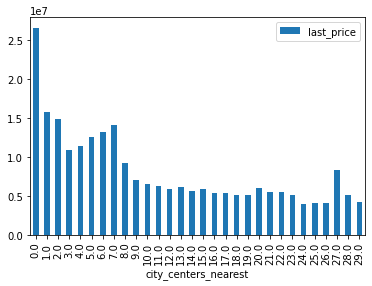

In [66]:
# Расстояние до центра на графике изобразим
(
    data[data['locality_name']=='санкт-петербург']
    .pivot_table(
        index='city_centers_nearest',
        values='last_price',
        aggfunc='mean')
    .plot(kind='bar')
);

     Наблюдаем большой отрыв недвижимости до 1км.
Также видно, что более низкие цены на недвижимость на расстоянии 1-7км.
Далее цена стремительно идет вниз на расстоянии от 8 до 27км.
Виден пик на 27км - предположительно это недвижимость в элитном р-не.

### Общий вывод

    Проведя аналитическую работу по объявлениям о продаже квартир в Санкт-Петербурге и соседних населённых пунктах можно постановить следующее:

- Выявлена прямая зависимость стоимости расстояния от квартиры до центра города - чем ближе к центру тем дороже. Средняя расстояние до центра - 13,7 км.
- Высота потолков является одним из самых сильным фактором цены: высота от 2.7 до 3.0 прямо влияет на цену кв. метра. 
- Квартиры на первом и других этажах дешевле чем на последнем. Также на первом этаже цена существенно ниже, чем на других
- При прочих равных цена квартир растет от 1 до 3 комнат, далее просматривается увеличение кол-ва комнат от 4 - стоимость м2 снижается.
- В целом можно выделить некоторую тенденцию - чем больше площадь квартиры, тем меньше цена м2 и квартиры в целом. Средняя площадь квартиры - 60м2.
- Стоимость м2 плавно растет до 7-8 этажа, после чего стоимость одного м2 понижается.
- Парки и водоемы поблизости немного добавляют стоимость м2.
- Самые высокие цены на квартиры, выставленных в апреле и августе, наименьшая - у объявлений выставленных в мае и июне.
- Наибольшая средняя цена квартир, которые выставили на продажу в начале недели - понедельник, вторник, наименьшая - у объявлений выставленных в конце недели - суббота, воскресенье. Наибольшее значение цены м2 у объявлений 14ого года, затем идет плавный спад до 2017г, далее относительно стремительный взлет к 2019г.
- Как правило, объявления размещаются на период до 3 месяцев, что считается довольно быстрой продажей, но достаточно объявлений также продолжает висеть более 7-8 месяцев. Среднее время продажи - 181 день.

**Чек-лист готовности проекта**

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл
- [x]  файлы изучены (выведены первые строки, метод `info()`, гистограммы и т.д.)
- [x]  определены пропущенные значения
- [x]  заполнены пропущенные значения там, где это возможно
- [x]  есть пояснение, какие пропущенные значения обнаружены
- [x]  изменены типы данных
- [x]  есть пояснение, в каких столбцах изменены типы и почему
- [x]  устранены неявные дубликаты в названиях населённых пунктов
- [x]  устранены редкие и выбивающиеся значения (аномалии) во всех столбцах
- [x]  посчитано и добавлено в таблицу: цена одного квадратного метра
- [x]  посчитано и добавлено в таблицу: день публикации объявления (0 - понедельник, 1 - вторник и т.д.)
- [x]  посчитано и добавлено в таблицу: месяц публикации объявления
- [x]  посчитано и добавлено в таблицу: год публикации объявления
- [x]  посчитано и добавлено в таблицу: тип этажа квартиры (значения — «первый», «последний», «другой»)
- [x]  посчитано и добавлено в таблицу: расстояние в км до центра города
- [x]  изучены и описаны следующие параметры:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - цена объекта;
        - количество комнат;
        - высота потолков;
        - этаж квартиры;
        - тип этажа квартиры («первый», «последний», «другой»);
        - общее количество этажей в доме;
        - расстояние до центра города в метрах;
        - расстояние до ближайшего аэропорта;
        - расстояние до ближайшего парка;
        - день и месяц публикации объявления
- [x]  построены гистограммы для каждого параметра
- [x]  выполнено задание: "Изучите, как быстро продавались квартиры (столбец days_exposition). Этот параметр показывает, сколько дней «висело» каждое объявление.
    - Постройте гистограмму.
    - Посчитайте среднее и медиану.
    - В ячейке типа markdown опишите, сколько обычно занимает продажа. Какие продажи можно считать быстрыми, а какие — необычно долгими?"
- [x]  выполнено задание: "Какие факторы больше всего влияют на общую (полную) стоимость объекта? Постройте графики, которые покажут зависимость цены от указанных ниже параметров. Для подготовки данных перед визуализацией вы можете использовать сводные таблицы."
        - общей площади;
        - жилой площади;
        - площади кухни;
        - количество комнат;
        - типа этажа, на котором расположена квартира (первый, последний, другой);
        - даты размещения (день недели, месяц, год);
- [x]  выполнено задание: "Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра. Эти данные можно найти по имени в столбце `locality_name`."
- [x]  выполнено задание: "Ранее вы посчитали расстояние до центра в километрах. Теперь выделите квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислите среднюю цену каждого километра. Опишите, как стоимость объектов зависит от расстояния до центра города."
- [x]  в каждом этапе есть промежуточные выводы
- [x]  есть общий вывод